## Synthetic Data Generation for GLMM to characterise how hard the task is for spinal cord data

In [1]:
import os
import sys
import numpy as np
from lib.clustering.glmm import GLMM
from utils import cluster_score, plot_probability_estimates
from visualize_data import visualize_data
from datetime import datetime

def generate_clusters(n = 100, d = 56, radius=1, n_clusters=2):
    
    def generate_point():
        point = np.random.normal(size=d)
        point /= np.linalg.norm(point)/radius
        return point
    means = [np.zeros(d)] + [generate_point() for point in range(n_clusters-1)]
    
    covariances =  [np.eye(d) for _ in range(n_clusters)]
    X = np.concatenate([np.random.multivariate_normal(mu, sigma, n//n_clusters) for mu, sigma in zip(means, covariances)])
    labels = np.concatenate([label*np.ones(n//n_clusters) for label in range(n_clusters)])
    
    indexes = np.array([np.arange(idx, idx + n//10) for idx in range(0, n, n//10)])
    np.random.shuffle(indexes)
    indexes = indexes.flatten()

    print("Data shape:", X.shape)
    return X[indexes], labels[indexes], means, covariances 


np.random.seed(3)
X, labels, centroid, covariance = generate_clusters(n=args.n, d=args.d, radius=args.radius, sigma=args.sigma)
mixture = GLMM(n_components=2, avg_degree=30, delta=2)
prediction = mixture.fit_predict(X)
gamma = mixture.predict_proba(X)
f1, silhouette = cluster_score(gamma, labels, X, prediction)
print("Activity Score:", f1)
print("Silhouette Score:", silhouette)

execution_command = " ".join(sys.argv)
current_timestamp = datetime.now().strftime("%Y%m%d-%H%M")
folder_name = f"data/runs/glmm-synthetic-{current_timestamp}"
os.makedirs(folder_name, exist_ok=True)
with open(os.path.join(folder_name, "command.txt"), "w") as file:
    file.write(f"{execution_command}\n")
    file.write(f"Activity Score: {f1}\n")
    file.write(f"Silhouette Score: {silhouette}\n")

mean_class_0 = np.zeros(args.d)
visualize_data(mean_class_0, covariance, path=os.path.join(folder_name, "synthetic_class_0_"), full=False)
visualize_data(centroid, covariance, path=os.path.join(folder_name, "synthetic_class_1_"), full=False)

for cluster in range(2):
    visualize_data(mixture.means_[cluster], np.abs(mixture.laplacians_[cluster]), path=os.path.join(folder_name, f"found_cluster_{cluster}_"), full=False)

plot_probability_estimates(gamma, labels)


In [11]:
import numpy as np

generate_random_cov = lambda D: (A := np.random.randn(D, D)) @ A.T + 1e-5 * np.eye(D)
Sigma_a = generate_random_cov(2)

def rotate_sigma(Sigma_a, angle):
    vals_a, Ua = np.linalg.eigh(Sigma_a)
    n = Ua.shape[1]
    def givens_rotation(n, i, j, theta):
        """Construct an n x n Givens rotation matrix that rotates in the (i,j) plane by angle theta."""
        G = np.eye(n)
        G[i,i] = np.cos(theta)
        G[i,j] = -np.sin(theta)
        G[j,i] = np.sin(theta)
        G[j,j] = np.cos(theta)
        return G
    M = np.eye(n)
    angles = np.array([ angle for _ in range(n*(n-1)//2)], dtype=float )
    angles *= np.pi/180
    idx = 0
    for i in range(n):
        for j in range(i+1, n):
            G = givens_rotation(n, i, j, angles[idx])
            M = M @ G
            idx += 1

    Ub = Ua @ M
    Sigma_b = Ub @ np.diag(vals_a) @ Ub.T
    return Sigma_b

def principal_angle(Ua, Ub):
    Q = Ua.T @ Ub
    return (np.arccos(np.clip(Q, -1, 1)).flatten()*180/np.pi).min()  # Principal angles in radians

Data shape: (2000, 2)


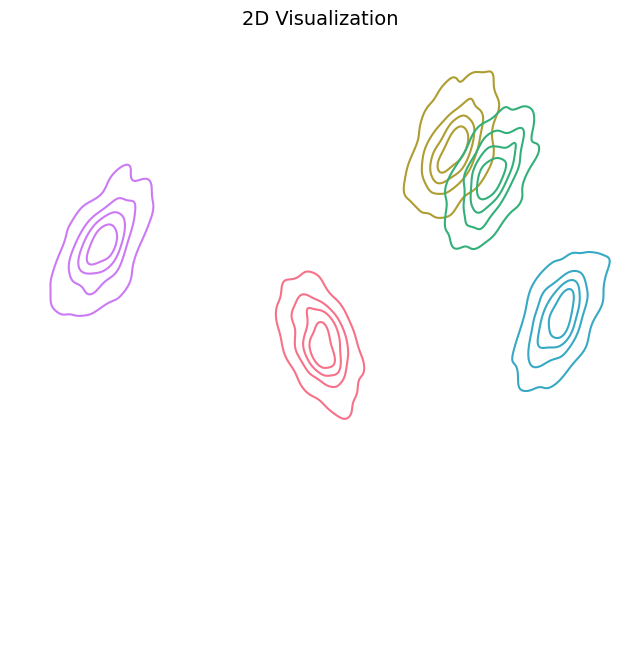

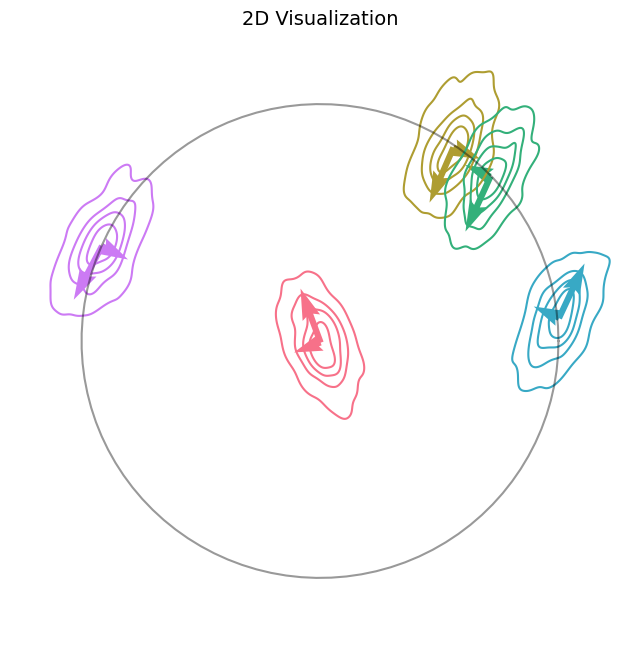

In [10]:
import os
import sys
import numpy as np
from lib.clustering.glmm import GLMM
from utils import cluster_score, plot_probability_estimates
from visualize_data import visualize_data
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

def generate_clusters(n_clusters=2, d = 56, radius=1, angle = 90, n = 100, plant_cov=None):
    
    def generate_point():
        point = np.random.normal(size=d)
        point /= np.linalg.norm(point)/radius
        return point
    means = [np.zeros(d)] + [generate_point() for point in range(n_clusters-1)]

    if plant_cov is None:
        sigma = generate_random_cov(d)
        covariances =  [sigma] + [rotate_sigma(sigma, angle) for _ in range(n_clusters)]
    else: 
        covariances = plant_cov
        
    X = np.concatenate([np.random.multivariate_normal(mu, sigma, n//n_clusters) for mu, sigma in zip(means, covariances)])
    labels = np.concatenate([label*np.ones(n//n_clusters) for label in range(n_clusters)])
    
    indexes = np.array([np.arange(idx, idx + n//10) for idx in range(0, n, n//10)])
    np.random.shuffle(indexes)
    indexes = indexes.flatten()

    print("Data shape:", X.shape)
    return X[indexes], labels[indexes], means, covariances 

x, l, means, cov = generate_clusters(n_clusters=5, n=2000, d=2, radius=10, angle=45)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot2D_gaussians(x, labels, bervose=False, radius=10):
    plt.figure(figsize=(8, 8))
    df = pd.DataFrame(np.concatenate([x, labels.reshape(-1, 1)], axis=1), columns = ['x', 'y', 'label'])
    palette = sns.color_palette("husl", len(df['label'].unique()))

    for cdx, idx in enumerate(sorted(df['label'].unique().tolist())):
        sns.kdeplot(data=df[df['label'] == idx], x="x", y="y", levels=5, color=palette[cdx])
    if bervose:
        # plot eigen vectors
        df_vec = df.groupby('label').apply(lambda gaus: np.linalg.svd(gaus[['x', 'y']].values - gaus[['x', 'y']].mean().values, full_matrices=True)).reset_index()
        df_vec.columns = ['label', 'svd']
        for rdx, row in df_vec.iterrows():
            mean = df[df['label'] == row['label']][['x', 'y']].mean().tolist()
            for vdx, (vec, scale) in enumerate(zip(row['svd'][2], row['svd'][1])):
                plt.quiver(mean[0], mean[1], scale*vec[0], scale*vec[1], angles='xy', scale_units = 'xy', 
                           alpha=1, scale=10, color=palette[int(row['label'])], width = 0.01)

        # plot hypersphere
        theta = np.linspace(0, 2 * np.pi, 100)
        plt.plot(radius*np.cos(theta), radius*np.sin(theta), color='k', alpha=0.4)
    
    lim = radius + 3*np.sqrt(1)
    plt.xlim(-lim, lim); plt.ylim(-lim, lim)
    plt.title('2D Visualization', fontsize=14)
    plt.axis('off')
    plt.show()
plot2D_gaussians(x, l, bervose=False)
plot2D_gaussians(x, l, bervose=True)

Data shape: (4000, 2)


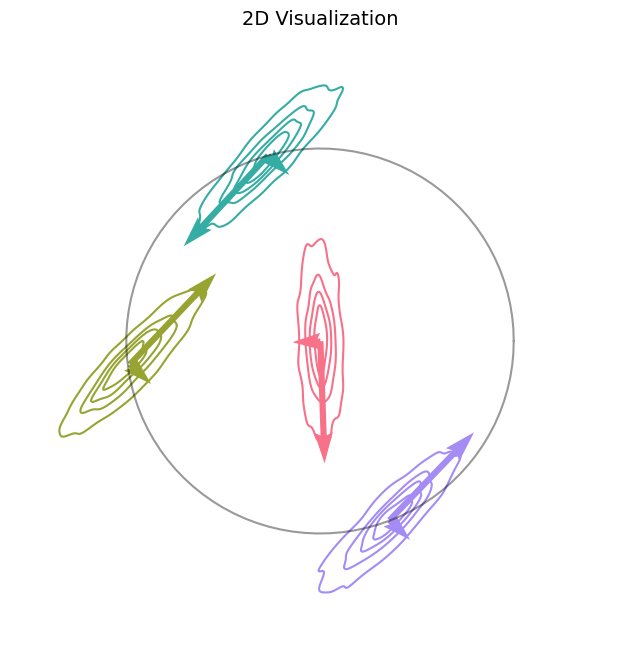

In [179]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from lib.clustering.glmm import GLMM
from visualize_data import visualize_data
from utils import cluster_score, plot_probability_estimates
warnings.filterwarnings("ignore")

def rotate_sigma(sigma, angle_rad):
    """
    Rotate a covariance by an angle with Givens rotation QR decomposition
    """
    vals_a, Ua = np.linalg.eigh(sigma)
    n = Ua.shape[1]

    M = np.eye(n)
    for i in range(n):
        for j in range(i + 1, n):
            G = np.eye(n)
            c, s = np.cos(angle_rad), np.sin(angle_rad)
            G[i, i], G[i, j], G[j, i], G[j, j] = c, -s, s, c
            M = M @ G
    Ub = Ua @ M
    return Ub @ np.diag(vals_a) @ Ub.T

def principal_angle(Ua, Ub):
    """
    Tells you the minimum angle rotation from two matrix eigenvectors from SVD or EVD.
    """
    Q = Ua.T @ Ub
    return np.arccos(np.clip(Q, -1, 1)), (np.arccos(np.clip(Q, -1, 1)).flatten()*180/np.pi).min()

def generate_point(radius, d):
    point = np.random.normal(size=d)
    point /= np.linalg.norm(point)/radius
    return point

def generate_random_cov(d):
    A = np.random.randn(d, d)
    cov = A @ A.T + 1e-5 * np.eye(d)
    return cov / np.max(np.diag(cov))

def generate_clusters(n_clusters=2, d = 56, radius=1, angle = 90, n = 100, plant_cov=None, plant_point=None):
    """
    Generate synthetic data
    """
    means = [np.zeros(d)] + [generate_point(radius, d) for point in range(n_clusters-1)]

    if plant_cov is None:
        sigma = generate_random_cov(d)
        covariances =  [sigma] + [rotate_sigma(sigma, np.radians(angle)) for _ in range(n_clusters)]
    else: 
        if isinstance(plant_cov, list):
            covariances = plant_cov
        else: covariances = [plant_cov] + [rotate_sigma(plant_cov, np.radians(angle)) for _ in range(n_clusters)]
    
    if plant_point is not None: 
        means = plant_point

    X = np.concatenate([np.random.multivariate_normal(mu, sigma, n//n_clusters) for mu, sigma in zip(means, covariances)])
    labels = np.concatenate([label*np.ones(n//n_clusters) for label in range(n_clusters)])
    
    indexes = np.array([np.arange(idx, idx + n//10) for idx in range(0, n, n//10)])
    np.random.shuffle(indexes)
    indexes = indexes.flatten()

    print("Data shape:", X.shape)
    return X[indexes], labels[indexes], means, covariances 

def plot2D_gaussians(x, labels, bervose=False, radius=10, ax=None, stats=None):
    if x.shape[1] > 2: x = x[:, :2]
    
    if ax is not None:
        ax.clear()
    else:
        plt.figure(figsize=(8, 8))
        ax = plt.gca()

    df = pd.DataFrame(np.concatenate([x, labels.reshape(-1, 1)], axis=1), columns = ['x', 'y', 'label'])
    palette = sns.color_palette("husl", len(df['label'].unique()))

    for cdx, idx in enumerate(sorted(df['label'].unique().tolist())):
        sns.kdeplot(data=df[df['label'] == idx], x="x", y="y", levels=5, color=palette[cdx], ax=ax)
    if bervose:
        # plot eigen vectors
        df_vec = df.groupby('label').apply(lambda gaus: np.linalg.svd(gaus[['x', 'y']].values - gaus[['x', 'y']].mean().values, full_matrices=True)).reset_index()
        df_vec.columns = ['label', 'svd']
        for rdx, row in df_vec.iterrows():
            mean = df[df['label'] == row['label']][['x', 'y']].mean().tolist()
            for vdx, (vec, scale) in enumerate(zip(row['svd'][2], row['svd'][1])):
                ax.quiver(mean[0], mean[1], scale*vec[0], scale*vec[1], angles='xy', scale_units = 'xy', 
                           alpha=1, scale=10, color=palette[int(row['label'])], width = 0.01)

        # plot hypersphere
        theta = np.linspace(0, 2 * np.pi, 100)
        ax.plot(radius*np.cos(theta), radius*np.sin(theta), color='k', alpha=0.4)
    
    lim = radius + 3*np.sqrt(1)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    if stats is None:
        ax.set_title('2D Visualization', fontsize=14)
    else: ax.set_title(f'Visualization r = {stats[0]}, $\\theta$ = {stats[1]}')
    ax.axis('off')
    if ax is not None:
        plt.show()


x, l, means, cov = generate_clusters(n_clusters=4, n=4000, d=2, radius=5, angle=45)
plot2D_gaussians(x, l, radius=5, bervose=True)

In [152]:
def principle_angle_from_X(x, l, k=1):
    x_a = x[l == 0]
    x_b = x[l == 1]
    sigma_a = np.cov(x_a.T)
    sigma_b = np.cov(x_b.T)
    _, eigvecs_a = np.linalg.eigh(sigma_a)
    _, eigvecs_b = np.linalg.eigh(sigma_b)

    Ua = eigvecs_a[:, -k:]
    Ub = eigvecs_b[:, -k:]
    print(Ua, Ub)

    M = Ua.T @ Ub
    print(M)
    _, s, _ = np.linalg.svd(M)
    return np.arccos(np.clip(s, -1, 1)) *180/np.pi
principle_angle_from_X(x, l.astype(int), k=1)

[[ 0.31388051]
 [-0.70835128]
 [ 0.63223215]] [[-0.91751647]
 [ 0.38868084]
 [-0.0842065 ]]
[[-0.61655117]]


array([51.93528246])

In [87]:

def principle_angle_from_X(x, l):
    x_a = x[l == 0]
    x_b = x[l == 1]

    sigma_a = np.cov(x_a, rowvar=False)
    sigma_b = np.cov(x_b, rowvar=False)

    eigvals_a, eigvecs_a = np.linalg.eigh(sigma_a)
    eigvals_b, eigvecs_b = np.linalg.eigh(sigma_b)
    #print(eigvals_a, eigvecs_a)
    #print(eigvals_b, eigvecs_b)

    def principal_angle(Ua, Ub):
        Q = Ua.T @ Ub
        return np.arccos(np.clip(Q, -1, 1)), (np.arccos(np.clip(Q, -1, 1)).flatten() * 180 / np.pi).min()
    sigval = np.linalg.svd(eigvecs_a.T @ eigvecs_b, compute_uv=False)
    def principal_angles(U, V):
        M = np.dot(U.T, V)
        _, s, _ = np.linalg.svd(M)
        return np.arccos(np.clip(s, -1, 1))
    
    return principal_angles(eigvecs_a.T, eigvecs_b.T)
principle_angle_from_X(x, l.astype(int))

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.98023224e-08])

In [154]:
import numpy as np
from utils import z_score


spinal_data = z_score(np.load("data/fmri/spinal_data.npy"))
activity = np.tile(np.load('data/resources/activity.npy'), 30)
print(spinal_data.shape, activity.shape)

rest, active = spinal_data[activity == 0], spinal_data[activity == 1]

(3750, 56) (3750,)


In [207]:
def principle_angle_from_X(x, l, k=1):
    x_a = x[l == 0]
    x_b = x[l == 1]
    sigma_a = np.cov(x_a.T)
    sigma_b = np.cov(x_b.T)
    _, eigvecs_a = np.linalg.eigh(sigma_a)
    _, eigvecs_b = np.linalg.eigh(sigma_b)
    
    Ua = eigvecs_a[:, -k:]
    Ub = eigvecs_b[:, -k:]

    M = Ua.T @ Ub
    _, s, _ = np.linalg.svd(M)

    return np.arccos(np.clip(s, -1, 1)) *180/np.pi

print(principle_angle_from_X(spinal_data, activity, k=28))
angles = []
for k in range(1, 28):
    angles.append(principle_angle_from_X(spinal_data, activity, k=k))
np.concatenate(angles).mean()

[ 0.34039678  0.65990449  2.28824574  2.5437656   2.990095    3.43070703
  5.28928129  6.48101614  6.71923961  8.35251144  8.82523369  9.70173385
 11.67928566 12.94150086 14.77500806 16.78200243 17.57754692 19.27188407
 23.42210041 28.91524481 31.17265604 34.4053672  40.64827554 47.24872697
 51.47903076 57.76572223 69.90950636 84.92134885]


28.150895506741335

In [211]:
def principle_angle_from_X(x, l):
    x_a = x[l == 0]
    x_b = x[l == 1]
    sigma_a = np.cov(x_a.T)
    sigma_b = np.cov(x_b.T)
    _, eigvecs_a = np.linalg.eigh(sigma_a)
    _, eigvecs_b = np.linalg.eigh(sigma_b)

    angles = []
    for k in range(1, len(eigvecs_a)):
        Ua = eigvecs_a[:, -k:]
        Ub = eigvecs_b[:, -k:]
        M = Ua.T @ Ub
        _, s, _ = np.linalg.svd(M)
        if  np.sum(np.abs(s - 1) < 0.05)/len(s) > 0.5:
            print("collapse @", k)
            break
        angles.append(np.arccos(np.clip(s, -1, 1)) *180/np.pi)
    if not angles: return 0

    return np.concatenate(angles).mean()


print(principle_angle_from_X(spinal_data, activity))

#angles = []
#for k in range(1, 28):
#    angles.append(principle_angle_from_X(spinal_data, activity, k=k))
#np.concatenate(angles).mean()

collapse @ 23
30.22941670175836


In [ ]:
def principle_angle_from_X(x, l):
    x_a = x[l == 0]
    x_b = x[l == 1]
    sigma_a = np.cov(x_a.T)
    sigma_b = np.cov(x_b.T)
    _, eigvecs_a = np.linalg.eigh(sigma_a)
    _, eigvecs_b = np.linalg.eigh(sigma_b)

    angles = []
    for k in range(1, len(eigvecs_a)):
        Ua = eigvecs_a[:, -k:]
        Ub = eigvecs_b[:, -k:]
        M = Ua.T @ Ub
        _, s, _ = np.linalg.svd(M)
        if  np.all(s==1):
            print("collapse @", k)
            break
        angles.append(np.arccos(np.clip(s, -1, 1)) *180/np.pi)
    if not angles: return 0

    return np.concatenate(angles).mean()



spinal cord radius 0.4522147347170753
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
spinal cord theta 0.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]

 spinal cord theta (SVD) 0.0


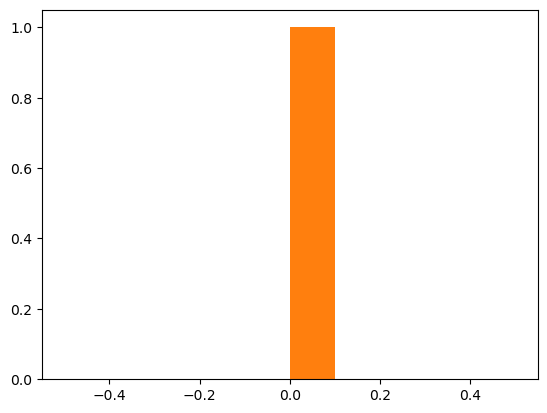

In [5]:
import matplotlib.pyplot as plt

def principle_angle_from_X(x, l):
    x_a = x[l == 0]
    x_b = x[l == 1]

    sigma_a = np.cov(x_a, rowvar=False)
    sigma_b = np.cov(x_b, rowvar=False)

    eigvals_a, eigvecs_a = np.linalg.eigh(sigma_a)
    eigvals_b, eigvecs_b = np.linalg.eigh(sigma_b)
    def principal_angle(Ua, Ub):
        Q = Ua.T @ Ub
        return np.arccos(np.clip(Q, -1, 1)), (np.arccos(np.clip(Q, -1, 1)).flatten() * 180 / np.pi).min()
    angles, min_angle = principal_angle(eigvecs_a, eigvecs_b)
    print('spinal cord radius', np.linalg.norm(x_a.mean(axis=0) - x_b.mean(axis=0)))
    return angles, min_angle
principle_angles_from_X



U_rest = np.linalg.svd(rest, full_matrices=True)[2]
U_active = np.linalg.svd(active, full_matrices=True)[2]

sigma_rest = rest.T @ rest
sigma_active = active.T @ active

_, U_cov_rest = np.linalg.eigh(sigma_rest)
_, U_cov_active = np.linalg.eigh(sigma_active)

print('spinal cord theta', principal_angle(U_cov_rest, U_cov_active)[1])

print('\n spinal cord theta (SVD)', principal_angle(U_rest, U_active)[1])

Data shape: (2000, 2)


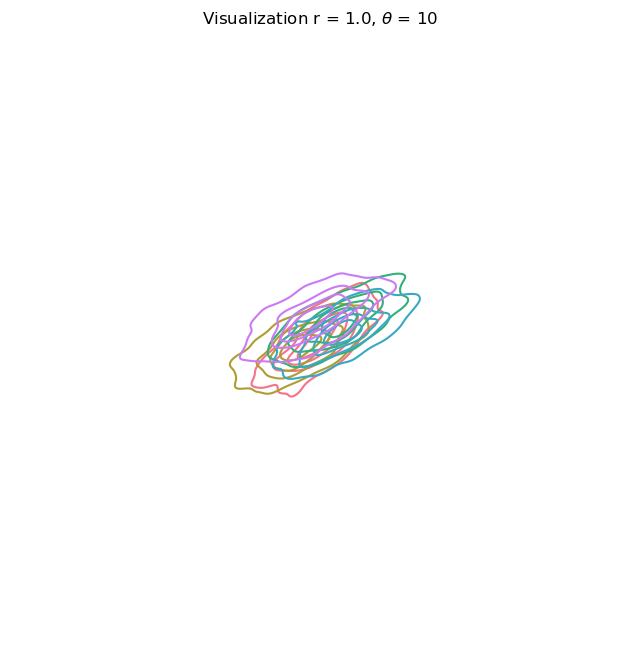

Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)


In [21]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.axis('off')
radii = np.linspace(1,10,10)
angles = np.linspace(0,180,10)
frames = [(r,10,False) for r in radii] + [(10,a,False) for a in angles] + [(r,10,True) for r in radii] + [(10,a,True) for a in angles]

means = [np.zeros(2)] + [generate_point(1, 2) for point in range(5-1)]
def init():
    return []

def update(frame):
    ax.clear()
    r, a, b = frame
    x, l, m, c = generate_clusters(n_clusters=5, n=2000, d=2, radius=r, angle=a, plant_cov=np.array([[1, 0.6], [0.6, 0.7]]), plant_point=r*np.array(means))
    plot2D_gaussians(x, l, bervose=b, radius=10, ax=ax, stats=(r, a))
    return []

ani = animation.FuncAnimation(fig, update, frames=frames, init_func=init, blit=False, repeat=False)
ani.save('sdemo.mp4', writer='ffmpeg', fps=2)

Data shape: (2000, 2)


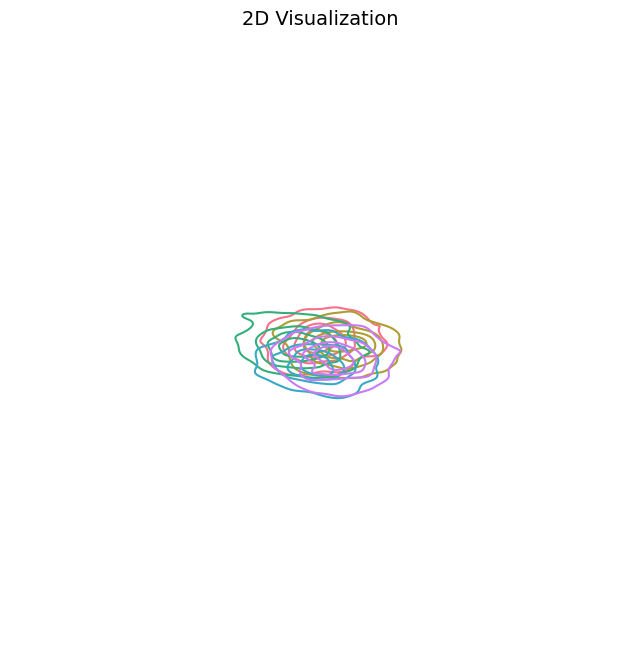

Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)
Data shape: (2000, 2)


In [22]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.axis('off')
radii = np.linspace(1,10,10)
angles = np.linspace(0,180,10)
frames = [(r,10,False) for r in radii] + [(10,a,False) for a in angles] + [(r,10,True) for r in radii] + [(10,a,True) for a in angles]

means = [np.zeros(2)] + [generate_point(1, 2) for point in range(5-1)]
def init():
    return []

def update(frame):
    ax.clear()
    r, a, b = frame
    x, l, m, c = generate_clusters(n_clusters=5, n=2000, d=2, radius=r, angle=a)#, plant_cov=np.array([[1, 0.6], [0.6, 0.7]]), plant_point=r*np.array(means))
    plot2D_gaussians(x, l, bervose=b, radius=10, ax=ax)#, stats=(r, a))
    return []

ani = animation.FuncAnimation(fig, update, frames=frames, init_func=init, blit=False, repeat=False)
ani.save('sdemo_unnormalized.mp4', writer='ffmpeg', fps=2)

In [33]:
radii = np.round(4*np.linspace(1, 5, 10))/4
angles = np.linspace(0, 90, 10)  
radii, angles

(array([1.  , 1.5 , 2.  , 2.25, 2.75, 3.25, 3.75, 4.  , 4.5 , 5.  ]),
 array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]))

In [7]:
import numpy as np
radii = np.round(5*np.linspace(0, 3, 15))/5
angles = np.round(np.linspace(0, 60, 15))
radii, angles

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.6, 1.8, 2. , 2.2, 2.4, 2.6,
        2.8, 3. ]),
 array([ 0.,  4.,  9., 13., 17., 21., 26., 30., 34., 39., 43., 47., 51.,
        56., 60.]))

In [27]:
import os, sys, warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lib.clustering.glmm import GLMM
from utils import cluster_score
warnings.filterwarnings("ignore")

def generate_clusters(n_clusters=2, d=2, radius=1, angle=0, n=100, plant_cov=None, plant_point=None):
    def rotate_sigma(sigma, angle_rad):
        vals_a, Ua = np.linalg.eigh(sigma)
        n = Ua.shape[1]
        M = np.eye(n)
        for i in range(n):
            for j in range(i + 1, n):
                G = np.eye(n)
                c, s = np.cos(angle_rad), np.sin(angle_rad)
                G[i,i], G[i,j], G[j,i], G[j,j] = c, -s, s, c
                M = M @ G
        Ub = Ua @ M
        return Ub @ np.diag(vals_a) @ Ub.T
    def generate_point(radius, d):
        point = np.random.normal(size=d)
        point /= np.linalg.norm(point)/radius
        return point
    def generate_random_cov(d):
        A = np.random.randn(d, d)
        cov = A @ A.T + 1e-5 * np.eye(d)
        return cov / np.max(np.diag(cov))
    means = [np.zeros(d)] + [generate_point(radius, d) for _ in range(n_clusters-1)]
    if plant_cov is None:
        sigma = generate_random_cov(d)
        covariances = [sigma] + [rotate_sigma(sigma, np.radians(angle)) for _ in range(n_clusters-1)]
    else:
        covariances = [plant_cov] + [rotate_sigma(plant_cov, np.radians(angle)) for _ in range(n_clusters-1)]
    if plant_point is not None:
        means = plant_point
    X = np.concatenate([np.random.multivariate_normal(mu, sig, n//n_clusters) for mu, sig in zip(means, covariances)])
    labels = np.concatenate([i*np.ones(n//n_clusters) for i in range(n_clusters)])
    idx = np.arange(n)
    np.random.shuffle(idx)
    return X[idx], labels[idx]

radii = np.round(4*np.linspace(1, 5, 10))/4
angles = np.linspace(0, 90, 10)   

f1_mean = np.zeros((len(radii), len(angles)))
f1_std = np.zeros((len(radii), len(angles)))

for i, r in enumerate(radii):
    for j, a in enumerate(angles):
        scores = []
        for _ in range(5):
            X, labels = generate_clusters(n_clusters=2, d=56, radius=r, angle=a, n=2000)
            mixture = GLMM(n_components=2, avg_degree=30, delta=2)
            pred = mixture.fit_predict(X)
            gamma = mixture.predict_proba(X)
            f1, _ = cluster_score(gamma, labels, X, pred)
            scores.append(f1.max())
        f1_mean[i, j] = np.mean(scores)
        f1_std[i, j] = np.std(scores)

plt.figure(figsize=(8, 6))
sns.heatmap(f1_mean, xticklabels=np.round(angles, 2), yticklabels=np.round(radii, 2), annot=True, cmap="viridis")
plt.xlabel("Angle")
plt.ylabel("Radius")
plt.title("Mean F1 Scores")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(f1_std, xticklabels=np.round(angles, 2), yticklabels=np.round(radii, 2), annot=True, cmap="viridis")
plt.xlabel("Angle")
plt.ylabel("Radius")
plt.title("Std F1 Scores")
plt.show()

KeyboardInterrupt: 

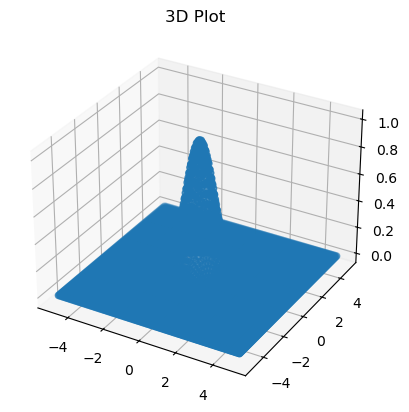

In [3]:
import numpy as np
import matplotlib.pyplot as plt

ax = plt.axes(projection="3d")

mesh_size=100
max=mesh_size**2
xyz = np.zeros((3,max))
nx, ny = (mesh_size,mesh_size)
x = np.linspace(-5, 5, nx)
y = np.linspace(-5, 5, ny)
xv, yv = np.meshgrid(x, y)
xyz[0]=xv.reshape(max,)
xyz[1]=yv.reshape(max,)
xyz[2]=np.exp(-(xyz[0]**2+xyz[1]**2))

ax.scatter(xyz[0],xyz[1],xyz[2])
ax.set_title("3D Plot")

plt.show()

In [18]:
cov1 = np.array([[2, -1], 
       [-1, 2]])

cov2 = np.array([[2, 1], 
       [1, 2]])
np.linalg.inv(cov1), cov1 @ cov2, np.matmul(cov1, cov2), np.dot(cov1, cov2)

(array([[0.66666667, 0.33333333],
        [0.33333333, 0.66666667]]),
 array([[3, 0],
        [0, 3]]),
 array([[3, 0],
        [0, 3]]),
 array([[3, 0],
        [0, 3]]))

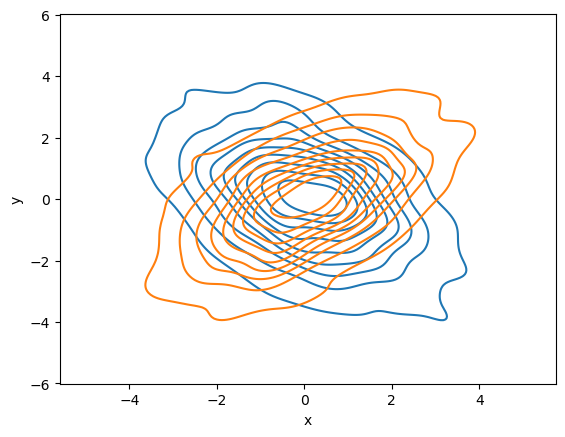

[1. 1.]
[-1.  1.]


(array([2.10734243e-08, 2.10734243e-08]), 1.2074182697257333e-06)

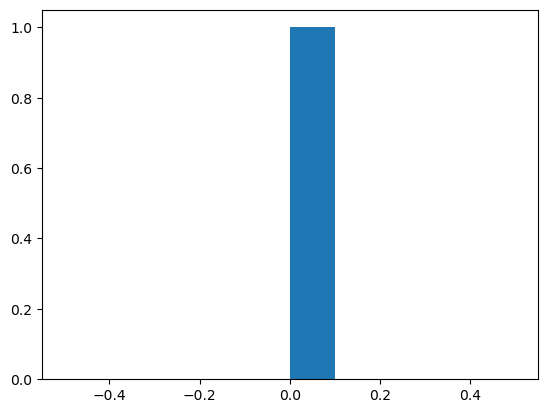

In [11]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
mean = (0, 0)
cov = [[2, -1], 
       [-1, 2]]
data = pd.DataFrame(np.random.multivariate_normal(mean, cov, 1000), columns = ['x', 'y'])

sns.kdeplot(data=data,x="x", y="y", levels=10)
mean = (0, 0)
cov1 = [[2, 1], 
       [1, 2]]

data = pd.DataFrame(np.random.multivariate_normal(mean, cov1, 1000), columns = ['x', 'y'])

sns.kdeplot(data=data,x="x", y="y", levels=10)

#data = pd.DataFrame(np.random.multivariate_normal(mean, cov, 1000), columns = ['x', 'y'])

#sns.kdeplot(data=data,x="x", y="y", levels=10)
plt.show()
def principal_angle(Ua, Ub):
    """
    Computes all principal angles between the subspaces spanned by the columns
    of Ua and Ub, returning both the array of angles (in radians) and the 
    smallest principal angle (in degrees).
    
    Parameters
    ----------
    Ua : np.ndarray
        An orthonormal (or at least column-wise independent) matrix whose columns
        span a subspace.
    Ub : np.ndarray
        An orthonormal (or at least column-wise independent) matrix whose columns
        span another subspace.

    Returns
    -------
    angles : np.ndarray
        The array of principal angles (in radians).
    min_angle_degs : float
        The smallest principal angle (in degrees).
    """
    Q = Ua.T @ Ub
    
    svals = np.linalg.svd(Q, compute_uv=False)
    print(svals)
    evals, evec = np.linalg.eigh(Q)
    print(evals)
    angles = np.arccos(np.clip(svals, -1.0, 1.0))
    
    # Smallest angle in degrees
    min_angle_degs = np.degrees(np.min(angles))
    plt.hist(min_angle_degs)
    return angles, min_angle_degs
principal_angle(np.linalg.eigh(cov)[1], np.linalg.eigh(cov1)[1])

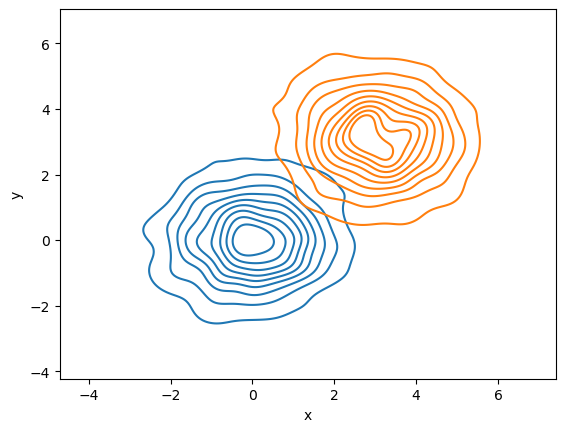

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
mean = (0, 0)
cov = [[1, 0], 
       [0, 1]]
data = pd.DataFrame(np.random.multivariate_normal(mean, cov, 1000), columns = ['x', 'y'])

sns.kdeplot(data=data,x="x", y="y", levels=10)
mean = (3, 3)
#cov = [[, 1], 
#       [1, 2]]

data = pd.DataFrame(np.random.multivariate_normal(mean, cov, 1000), columns = ['x', 'y'])

sns.kdeplot(data=data,x="x", y="y", levels=10)

#data = pd.DataFrame(np.random.multivariate_normal(mean, cov, 1000), columns = ['x', 'y'])

#sns.kdeplot(data=data,x="x", y="y", levels=10)
plt.show()

In [58]:
d = 3
stair_d = int(d*(d+1)/2)
print(d, stair_d)
vech1 = np.random.choice([0, 1], size=stair_d)
vech2 = (vech1==0).astype(int)
vech1 @ vech2

3 6


0

In [62]:
m1 = np.array([[1, -0.5],
               [-0.5, 1]])
m1.T @ m1

array([[ 1.25, -1.  ],
       [-1.  ,  1.25]])

In [60]:
m1 = np.array([[1, -0.5],
               [-0.5, 1]])
m2 = np.array([[1, 0.5],
               [0.5, 1]])
m1 @ m2

array([[0.75, 0.  ],
       [0.  , 0.75]])

In [ ]:
np.triu